<a href="https://colab.research.google.com/github/chavgova/My-AI/blob/master/emotion_recognition_07_97%25%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT

In [2]:
#this is the copy of another projecct and ill make changes to see how i can make it better 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from matplotlib.axis import Axis
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers
import os

In [ ]:
from google.colab import drive
import os

path = '/content/drive/My Drive/My_AI/RawData'

mylist = []
mylist = os.listdir(path)

#print(mylist)	



In [ ]:
print(len(mylist))

4642


LABLES

In [ ]:
import re

feeling_list=[]
dataset = ''

for item in mylist:
    file_label = item[6:-16]
    try:
      file_label = int(file_label)
      dataset = 'RAVDESS'
    except:
      if (item[:1] == 'Y') or (item[:1] == 'O'):
        file_label = re.split('_|\.', item)[2]
        dataset = 'TESS'
      else: dataset = 'SAVEE'

    if dataset == 'RAVDESS':
      if int(item[18:-4])%2==0:  #female
          if file_label == 1:
            feeling_list.append('female_neutral')
          elif file_label == 2:
            feeling_list.append('female_calm')
          elif file_label == 3:
            feeling_list.append('female_happy')
          elif file_label == 4:
            feeling_list.append('female_sad')
          elif file_label == 5:
            feeling_list.append('female_angry')
          elif file_label == 6:
            feeling_list.append('female_fearful')
          elif file_label == 7:
            feeling_list.append('female_disgust')
          elif file_label == 8:
            feeling_list.append('female_surprised')
      else:
          if file_label== 1:
            feeling_list.append('male_neutral')
          elif file_label == 2:
            feeling_list.append('male_calm')
          elif file_label == 3:
            feeling_list.append('male_happy')
          elif file_label == 4:
            feeling_list.append('male_sad')
          elif file_label == 5:
            feeling_list.append('male_angry')
          elif file_label == 6:
            feeling_list.append('male_fearful')
          elif file_label == 7:
            feeling_list.append('male_disgust')
          elif file_label == 8:
            feeling_list.append('male_surprised')

    elif dataset == 'TESS':
      if file_label == 'neutral': feeling_list.append('female_neutral')
      elif file_label == 'angry': feeling_list.append('female_angry')
      elif file_label == 'disgust': feeling_list.append('female_disgust')
      elif file_label == 'ps': feeling_list.append('female_surprised')
      elif file_label == 'happy': feeling_list.append('female_happy')
      elif file_label == 'sad': feeling_list.append('female_sad')
      elif file_label == 'fear': feeling_list.append('female_fearful')

    elif dataset == 'SAVEE':
      if item[:1]=='a':
        feeling_list.append('male_angry')
      elif item[:1]=='f':
        feeling_list.append('male_fearful')
      elif item[:1]=='h':
        feeling_list.append('male_happy')
      elif item[:1]=='n':
        feeling_list.append('male_neutral')
      elif item[:2]=='sa':
        feeling_list.append('male_sad')
      elif item[:2]=='su':
        feeling_list.append('male_surprised')
      elif item[:1]=='d':
        feeling_list.append('male_disgust')


In [ ]:
import pandas as pd

labels = pd.DataFrame(feeling_list)
labels #[1600:1660]      #print

,0
0,female_fearful
1,female_surprised
2,female_disgust
3,female_fearful
4,female_angry
...,...
4637,male_sad
4638,male_neutral
4639,male_neutral
4640,male_happy


Getting the features of audio files using librosa

In [4]:
import librosa
import numpy as np

def extract_feature(my_file, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    X, sample_rate = librosa.core.load(my_file)
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))  # 40 values 
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))  # 12 values 
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))  # 128 values 
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast)) # 7 values 
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz)) # 6 values 

    return result

#f = os.fspath('/content/drive/My Drive/My_AI/RawData/03-01-08-01-01-02-01.wav')
#a = extract_feature(f, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True)
#print(a, a.shape)

In [ ]:
data_frame = pd.DataFrame(columns=['all_features'])
bookmark=0

#mylist = mylist[:100]
for index,y in enumerate(mylist):
      all_features_ndarray = extract_feature('/content/drive/My Drive/My_AI/RawData/'+ y, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True)
      data_frame.loc[bookmark] = [all_features_ndarray]
      bookmark=bookmark+1
        
#df[:5]    #print 


In [ ]:
data_frame

,all_features
0,"[-316.3982820454405, 39.7822605437439, -19.189..."
1,"[-342.88055472969165, 45.95027168893386, -12.3..."
2,"[-419.17375831355355, 79.36795418715639, 4.317..."
3,"[-293.87641633233585, 22.448290415751732, -9.3..."
4,"[-367.20304493461066, 40.17211376308315, -2.72..."
...,...
4637,"[-386.0892486848382, 110.02557215362587, 21.23..."
4638,"[-442.40133523714957, 112.92528455032522, 34.9..."
4639,"[-422.7050269459787, 120.85873358076398, 28.69..."
4640,"[-302.1125750691463, 111.5075339801829, 5.2672..."


In [ ]:
data_frame = pd.DataFrame(data_frame['all_features'].values.tolist())
data_frame[:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192
0,-316.398282,39.782261,-19.189288,10.220406,-3.955771,-5.367594,-8.272648,-5.151310,-8.576905,6.269787,-18.821991,4.428211,-0.106290,1.069031,0.127908,-5.440494,-1.287617,8.693481,-3.554609,15.700572,10.750350,7.285267,2.611756,5.705450,-1.574549,7.675168,0.213019,1.292888,-0.059914,-0.239021,-3.433251,3.604023,-4.753794,3.056424,-1.128346,1.007652,-1.190492,1.005525,1.607905,3.564362,...,0.001503,0.001342,0.002295,0.002372,0.002861,0.006071,0.006472,0.008890,0.007342,0.005558,0.005838,0.005698,0.005810,0.005224,0.004468,0.006076,0.005546,0.006286,0.006116,0.011182,0.018300,0.012381,0.005446,0.009796,0.008335,0.003382,0.000305,13.868668,20.999650,21.803635,19.194679,20.722318,21.901160,32.323680,-0.003346,-0.014993,0.020096,-0.003074,-0.000737,0.012189
1,-342.880555,45.950272,-12.301437,9.037878,-17.194069,-13.218251,-8.020786,-17.228617,-14.822261,-2.137459,-10.392415,9.892669,-10.905327,10.679729,-1.748336,3.126162,8.133520,1.703298,-3.835112,2.226029,-3.639254,5.678473,-1.003672,2.825912,-0.287353,2.221059,3.942444,7.379460,3.065108,9.795497,3.641103,7.876033,6.162153,7.126329,2.823838,5.375054,-0.816559,5.629844,2.231022,2.599346,...,0.002129,0.001635,0.001341,0.000785,0.000476,0.000568,0.001456,0.001768,0.002265,0.002550,0.003186,0.004343,0.002630,0.002409,0.004420,0.007988,0.007283,0.005904,0.006900,0.006846,0.008745,0.006972,0.003461,0.003092,0.003775,0.002511,0.000264,17.622480,18.869340,22.381613,19.010813,20.511432,21.295596,31.370796,-0.006591,-0.008237,-0.013012,-0.001128,-0.000918,-0.002161
2,-419.173758,79.367954,4.317339,35.424460,-7.966875,-4.674928,-0.599713,-17.962315,-12.630474,-7.361007,-12.680626,0.716001,-8.898681,3.046107,-6.071597,-4.969251,5.618301,-5.994555,-6.884007,1.297542,-8.073998,1.653511,-2.665310,2.601730,-2.046081,0.588888,-2.019464,3.216928,4.282435,8.064075,-0.794268,5.343579,-0.834786,0.198284,0.655829,3.781555,5.973052,7.372418,6.851194,7.075016,...,0.000393,0.000156,0.000118,0.000213,0.000269,0.000675,0.000828,0.000593,0.000774,0.000674,0.000787,0.001000,0.001052,0.000936,0.001152,0.001685,0.002630,0.003414,0.003983,0.005403,0.007188,0.004412,0.001615,0.002020,0.003231,0.001068,0.000168,18.847273,20.424341,21.850558,17.300010,21.275250,21.865844,29.752038,-0.010095,-0.000362,-0.047308,-0.015524,-0.001998,-0.003304
3,-293.876416,22.448290,-9.335532,26.431156,-4.734249,2.973992,-2.389638,-10.468726,-2.792421,0.925244,-13.743108,8.317492,-8.206837,2.610541,0.372752,-2.467361,-0.495091,12.504432,2.665887,13.333836,6.096934,2.939573,-2.406452,4.838465,1.819071,9.418154,-0.115926,0.947575,-1.769516,3.020390,-4.262996,2.740926,-5.912998,-0.717437,-0.780768,3.394294,0.121856,5.221049,0.308147,2.509442,...,0.133340,0.131750,0.114145,0.108087,0.085247,0.071662,0.049761,0.042576,0.034288,0.023788,0.024551,0.025097,0.024018,0.028981,0.030698,0.035535,0.035312,0.031429,0.029649,0.039931,0.044069,0.031701,0.013745,0.018371,0.012888,0.005912,0.000552,13.557616,20.720947,21.244924,19.248067,21.323559,20.853838,31.759059,0.000611,-0.000084,-0.013852,-0.064953,0.006751,0.000230
4,-367.203045,40.172114,-2.722191,17.633493,-15.947783,-5.629244,0.581348,-18.207309,-2.655200,-3.220760,-18.233323,12.147264,-11.930273,5.846366,-1.782772,-4.524518,2.751071,0.070683,-5.328440,5.018463,-5.571851,-2.214062,-7.623350,-2.618450,-2.444535,-0.937296,-2.697148,4.923608,7.678478,14.626429,11.462202,15.358377,9.920862,7.825822,2.132594,4.316476,2.754338,7.616782,2.611640,0.899905,...,0.000616,0.000405,0.000610,0.000777,0.000929,0.002041,0.001509,0.001979,0.001734,0.002036,0.002950,0.004354,0.002887,0.003199,0.004200,0.007140,0.007721,0.006963,0.009832,0.018136,0.027777,0.011011,0.006270,0.011737,0.012987,0.008119,0.000792,18.718335,21.817464,23.389298

In [ ]:
data_frame_labels = pd.concat([data_frame,labels], axis=1)
data_frame_labels = data_frame_labels.rename(index=str, columns={"0": "label"})
data_frame_labels    #print

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,0
0,-316.398282,39.782261,-19.189288,10.220406,-3.955771,-5.367594,-8.272648,-5.151310,-8.576905,6.269787,-18.821991,4.428211,-0.106290,1.069031,0.127908,-5.440494,-1.287617,8.693481,-3.554609,15.700572,10.750350,7.285267,2.611756,5.705450,-1.574549,7.675168,0.213019,1.292888,-0.059914,-0.239021,-3.433251,3.604023,-4.753794,3.056424,-1.128346,1.007652,-1.190492,1.005525,1.607905,3.564362,...,0.001342,0.002295,0.002372,0.002861,0.006071,0.006472,0.008890,0.007342,0.005558,0.005838,0.005698,0.005810,0.005224,4.467806e-03,6.076175e-03,5.545964e-03,6.285772e-03,6.115529e-03,1.118162e-02,1.830000e-02,1.238102e-02,5.446300e-03,9.795647e-03,8.335074e-03,3.382275e-03,3.049260e-04,13.868668,20.999650,21.803635,19.194679,20.722318,21.901160,32.323680,-0.003346,-0.014993,0.020096,-0.003074,-0.000737,0.012189,female_fearful
1,-342.880555,45.950272,-12.301437,9.037878,-17.194069,-13.218251,-8.020786,-17.228617,-14.822261,-2.137459,-10.392415,9.892669,-10.905327,10.679729,-1.748336,3.126162,8.133520,1.703298,-3.835112,2.226029,-3.639254,5.678473,-1.003672,2.825912,-0.287353,2.221059,3.942444,7.379460,3.065108,9.795497,3.641103,7.876033,6.162153,7.126329,2.823838,5.375054,-0.816559,5.629844,2.231022,2.599346,...,0.001635,0.001341,0.000785,0.000476,0.000568,0.001456,0.001768,0.002265,0.002550,0.003186,0.004343,0.002630,0.002409,4.419637e-03,7.988392e-03,7.282747e-03,5.903650e-03,6.899837e-03,6.846244e-03,8.745193e-03,6.971703e-03,3.461123e-03,3.091562e-03,3.774827e-03,2.511465e-03,2.638007e-04,17.622480,18.869340,22.381613,19.010813,20.511432,21.295596,31.370796,-0.006591,-0.008237,-0.013012,-0.001128,-0.000918,-0.002161,female_surprised
2,-419.173758,79.367954,4.317339,35.424460,-7.966875,-4.674928,-0.599713,-17.962315,-12.630474,-7.361007,-12.680626,0.716001,-8.898681,3.046107,-6.071597,-4.969251,5.618301,-5.994555,-6.884007,1.297542,-8.073998,1.653511,-2.665310,2.601730,-2.046081,0.588888,-2.019464,3.216928,4.282435,8.064075,-0.794268,5.343579,-0.834786,0.198284,0.655829,3.781555,5.973052,7.372418,6.851194,7.075016,...,0.000156,0.000118,0.000213,0.000269,0.000675,0.000828,0.000593,0.000774,0.000674,0.000787,0.001000,0.001052,0.000936,1.152094e-03,1.684913e-03,2.629799e-03,3.414122e-03,3.983024e-03,5.403495e-03,7.188147e-03,4.411572e-03,1.614888e-03,2.019921e-03,3.231404e-03,1.068011e-03,1.677236e-04,18.847273,20.424341,21.850558,17.300010,21.275250,21.865844,29.752038,-0.010095,-0.000362,-0.047308,-0.015524,-0.001998,-0.003304,female_disgust
3,-293.876416,22.448290,-9.335532,26.431156,-4.734249,2.973992,-2.389638,-10.468726,-2.792421,0.925244,-13.743108,8.317492,-8.206837,2.610541,0.372752,-2.467361,-0.495091,12.504432,2.665887,13.333836,6.096934,2.939573,-2.406452,4.838465,1.819071,9.418154,-0.115926,0.947575,-1.769516,3.020390,-4.262996,2.740926,-5.912998,-0.717437,-0.780768,3.394294,0.121856,5.221049,0.308147,2.509442,...,0.131750,0.114145,0.108087,0.085247,0.071662,0.049761,0.042576,0.034288,0.023788,0.024551,0.025097,0.024018,0.028981,3.069844e-02,3.553510e-02,3.531232e-02,3.142908e-02,2.964862e-02,3.993142e-02,4.406870e-02,3.170089e-02,1.374528e-02,1.837071e-02,1.288842e-02,5.912021e-03,5.524261e-04,13.557616,20.720947,21.244924,19.248067,21.323559,20.853838,31.759059,0.000611,-0.000084,-0.013852,-0.064953,0.006751,0.000230,female_fearful
4,-367.203045,40.172114,-2.722191,17.633493,-15.947783,-5.629244,0.581348,-18.207309,-2.655200,-3.220760,-18.233323,12.147264,-11.930273,5.846366,-1.782772,-4.524518,2.751071,0.070683,-5.328440,5.018463,-5.571851,-2.214062,-7.623350,-2.618450,-2.444535,-0.937296,-2.697148,4.923608,7.678478,14.626429,11.462202,15.358377,9.920862,7.825822,2.132594,4.316476,2.754338,7.616782,2.611640,0.899905,...,0.000405,0.000610,0.000777,0.000929,0.00

In [ ]:
from sklearn.utils import shuffle
data_frame_labels = shuffle(data_frame_labels)
data_frame_labels
    #print 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,0
4297,-386.650391,112.257884,32.538729,55.920757,-11.472445,-6.594399,1.843466,3.526906,-9.719948,0.272446,-1.445023,-3.198936,-0.375138,-0.255478,6.328461,0.563520,-0.351230,1.548781,0.207166,-4.937928,1.837546,4.244088,-1.562167,-2.103844,0.455603,-2.398293,0.779373,4.251547,-1.899298,-1.610627,2.444678,3.864808,2.629697,0.894058,2.185032,1.397219,0.770842,2.446485,2.546150,1.161653,...,0.003463,0.003928,0.004474,0.004706,0.003627,0.002137,0.001433,0.001461,0.001296,0.001115,0.000800,0.000628,0.000380,0.000146,0.000079,0.000037,0.000022,0.000007,1.178434e-06,2.218054e-07,1.456940e-07,1.695652e-07,2.150158e-07,3.132837e-07,4.433140e-07,4.937361e-07,31.907075,14.005291,17.960368,19.927870,19.911672,21.453665,41.467029,0.004777,0.006754,-0.010323,0.021967,-0.006128,0.000325,male_neutral
834,-299.239255,30.882220,-7.624576,10.072476,2.918595,7.535072,7.858384,-3.801196,-3.628800,7.648708,-16.975320,9.263544,-2.766942,5.553412,1.373609,-5.312648,2.379411,10.954330,-7.677073,9.850016,1.903584,0.239441,-1.386426,1.123141,-4.174776,5.694065,-1.530366,1.730373,-0.904936,2.925451,-0.481910,8.660168,-1.469448,1.411537,-3.667900,3.204587,-1.019160,1.440307,-0.777350,1.583379,...,0.002249,0.002680,0.004001,0.004094,0.005872,0.004991,0.006134,0.005321,0.005888,0.003499,0.003331,0.003257,0.004754,0.005569,0.008002,0.009688,0.009170,0.008838,1.496371e-02,1.553523e-02,1.079949e-02,1.221468e-02,9.453340e-03,7.553417e-03,4.292128e-03,5.638074e-04,14.940984,20.068666,22.954760,18.938000,19.845712,22.225938,32.173067,-0.003287,0.011098,-0.023515,0.002380,0.002589,0.006072,female_fearful
3244,-631.708227,57.812441,-4.768079,16.799045,8.447084,-2.606081,-2.490354,-16.618601,-6.383768,3.015490,-4.969042,-2.969460,0.419781,1.585797,0.444348,-0.217427,-2.728774,6.449055,3.834710,7.104997,5.449810,6.690715,4.682529,10.976344,6.711400,7.975050,3.219573,7.475042,5.194706,4.736429,2.526778,2.135177,0.510637,2.935238,1.255736,2.274014,0.220092,1.068158,-1.494288,-0.523183,...,0.000014,0.000010,0.000007,0.000010,0.000008,0.000007,0.000008,0.000010,0.000011,0.000012,0.000011,0.000009,0.000007,0.000005,0.000005,0.000006,0.000005,0.000003,7.796216e-06,1.226196e-05,1.306513e-05,1.055138e-05,6.419980e-06,5.745188e-06,2.226130e-06,1.491235e-07,19.643638,17.510712,17.153081,16.500626,17.249775,18.054792,29.422410,-0.033702,0.019052,0.042628,-0.013429,0.021452,0.024160,female_sad
2640,-374.523802,68.953669,-6.685906,-11.386214,-19.893413,-8.508675,-19.998765,5.392508,-20.501850,-2.425175,-7.795433,4.309095,-4.337402,7.363466,-1.212704,-1.221640,3.182487,-7.681467,-3.607773,-14.531074,-8.442779,4.721248,1.504575,25.715152,31.718579,30.731710,23.506435,13.048573,-5.005679,2.128138,5.324190,7.924119,4.545379,-5.735838,1.562780,4.584207,1.656216,5.483671,-4.200719,-1.019264,...,0.001048,0.001063,0.000943,0.000927,0.000844,0.001453,0.002571,0.001788,0.003070,0.004082,0.003551,0.003179,0.002320,0.001538,0.001574,0.001422,0.001464,0.000897,5.048423e-04,3.514573e-04,2.229529e-04,1.441629e-04,1.475965e-04,1.462321e-04,5.302817e-05,2.691927e-06,27.402455,26.814298,28.764361,26.920250,26.024028,22.117023,34.723547,-0.009678,0.002519,-0.096969,-0.020635,0.007121,-0.010030,female_angry
4456,-387.594077,98.339948,11.329239,38.251268,19.280561,3.486709,-20.510567,-0.764894,-1.724635,-10.851204,3.536598,1.194512,-1.376731,-0.048999,7.186931,-2.778921,-2.712673,6.793405,-1.030662,-1.296969,-0.225800,-0.507843,1.198158,-1.930688,-0.527245,-2.198799,-1.828542,1.749463,-1.271855,0.246354,2.280063,2.205477,4.471838,8.225115,13.212310,15.069090,12.131318,7.867216,4.898035,4.327289,...,0.004526,0.004354,0.003556,0.002637,0.002151,0.000833,0.000293,0.000210,0.000112,0.000106,0.000065,0.000043,0.000024,0.000012,0.000008,0

SAVE DATASET FEATURES AND LABELS 

In [ ]:
import pickle

with open('/content/drive/My Drive/My_AI/datasets_RAVDESS-TESS-SAVEE_features&labels.pkl', 'wb') as f:
  pickle.dump(data_frame_labels, f)


LOAD DATASET FEATURES AND LABELS 

In [5]:
import pickle

with open('/content/drive/My Drive/My_AI/datasets_RAVDESS-TESS-SAVEE_features&labels.pkl', 'rb') as f:
  data_frame_labels = pickle.load(f)


Dividing the data into test and train

In [6]:
data_frame_labels_set = np.random.rand(len(data_frame_labels)) < 0.8

from sklearn.utils import shuffle
data_frame_labels = shuffle(data_frame_labels)

train = data_frame_labels[data_frame_labels_set]
test = data_frame_labels[~data_frame_labels_set]

In [44]:
test[0:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,0
2706,-449.901569,62.276134,22.690355,-0.460009,5.056943,3.809299,-9.135808,-2.762767,-17.664764,-4.458270,-13.117891,-9.189272,-5.671935,-3.674463,1.880057,1.330109,-0.414452,13.458885,0.418966,-0.139040,1.979843,1.552433,-1.340959,3.572533,0.209516,7.414759,2.589760,10.443966,1.529904,6.254732,0.657356,5.873176,2.623867,4.394743,0.888065,4.525781,1.104915,5.093542,5.295460,9.973043,...,0.001086,0.001071,0.000931,0.000877,0.001173,0.001056,0.001281,0.000791,0.000844,0.000742,0.000750,0.000679,0.000630,0.000534,4.066687e-04,2.497728e-04,2.469707e-04,3.035618e-04,4.307216e-04,4.953221e-04,4.552364e-04,4.708091e-04,5.301789e-04,3.799224e-04,1.280112e-04,1.021643e-05,24.716925,20.802590,21.551988,17.358732,18.577016,18.566204,31.773723,-0.007593,0.025162,-0.057697,0.060966,0.005745,0.012952,female_happy
1522,-530.270717,58.156372,26.336129,17.250805,13.327644,17.751436,-7.808188,-12.509855,-13.892730,5.652181,-12.255275,3.991810,-4.407224,6.792261,4.928624,3.675364,3.673447,5.492361,3.468645,-3.176772,4.615683,-1.202023,-3.067500,3.798210,-4.610046,1.729519,-4.166573,6.233025,-1.835156,3.109750,6.478440,9.380635,2.599150,9.789636,8.005449,8.429080,10.946670,19.227333,9.900398,10.247848,...,0.000143,0.000081,0.000129,0.000178,0.000106,0.000027,0.000106,0.000171,0.000121,0.000350,0.000830,0.000837,0.000385,0.000531,8.451393e-04,3.470903e-04,1.752425e-04,1.378688e-04,9.520506e-05,1.156964e-04,4.940842e-05,4.214433e-05,5.279090e-05,4.560647e-05,2.323718e-05,2.024584e-06,26.267815,20.963480,23.890578,20.174064,20.441111,19.206646,33.927779,-0.004951,0.044187,-0.040324,-0.009233,0.012523,0.052938,female_sad
4017,-370.376122,21.000562,-34.930289,-11.022658,-13.305772,-20.986175,-6.590354,-12.459492,-10.873764,2.193761,-10.466465,-0.749285,1.176124,5.782444,9.367664,7.605700,3.448836,-0.683987,-2.509529,-5.028317,1.850953,2.186072,-0.999946,-2.091702,-0.156410,1.288980,-0.823455,3.679541,0.672255,6.388494,-0.476927,1.940877,-1.541126,3.525521,-0.114694,3.215337,-0.174433,0.853195,-1.435538,2.719234,...,0.001175,0.001343,0.001810,0.001865,0.002047,0.002027,0.001846,0.001696,0.001963,0.002143,0.002711,0.005149,0.012229,0.011533,7.137930e-03,4.814626e-03,2.135897e-03,1.257558e-03,1.639131e-03,2.487180e-03,2.646962e-03,3.842846e-03,5.633474e-03,5.222770e-03,1.492950e-03,1.580656e-04,16.272767,13.758027,19.574048,20.250142,20.092785,21.272265,29.340585,-0.004651,0.021913,-0.029670,-0.016904,0.002604,0.002621,female_angry
581,-356.966057,34.783086,-8.509086,3.945203,-20.323754,-1.239432,-5.467129,-10.763873,-10.794280,2.742187,-8.270220,7.354330,-4.919847,5.316090,-0.192608,4.198214,0.336025,6.765846,-5.029816,5.438257,-4.385754,4.492257,-2.651171,0.646935,-2.896357,2.206160,-3.414224,6.644358,4.978320,7.469761,4.910099,8.981720,4.360911,6.367000,2.193685,6.965554,4.499216,6.411631,3.175026,3.902720,...,0.000949,0.001236,0.001238,0.001532,0.001906,0.001856,0.001521,0.001371,0.001643,0.002649,0.001907,0.001627,0.001298,0.001446,2.228864e-03,2.032356e-03,2.206375e-03,2.555145e-03,2.713509e-03,3.220873e-03,4.938002e-03,2.459647e-03,2.335946e-03,3.070876e-03,1.683546e-03,2.114446e-04,18.880514,19.050501,20.042726,18.276686,18.335859,19.183280,31.582817,-0.004688,0.009765,-0.012739,-0.019971,0.008923,0.002630,female_surprised
804,-343.217915,32.592146,-3.941084,24.603950,-18.831807,-6.736716,0.991936,-15.011476,-8.271952,-3.882542,-16.573220,13.243214,-13.899858,7.042132,-0.326961,-4.584630,1.960419,-1.895465,-5.941662,5.517026,-3.769599,1.461428,-7.425041,-3.087170,-3.420332,-1.247628,0.401451,5.871924,10.148203,18.614899,17.730915,18.369870,7.650813,4.158262,-2.068455,2.904605,3.445327,6.702976,2.442730,0.092989,...,0.000901,0.001250,0.002060,0.002163,0.003757,0.002836,0.003426,0

In [8]:
i = 0
tess_count = 0
savee_count = 0
ravdess_count = 0
for i in test:
  index = int(test.iloc[i].name)
  if index < 1400: tess_count = tess_count + 1
  elif index < 1550: savee_count = savee_count + 1
  elif index < 2950: tess_count = tess_count + 1
  elif index < 3331: savee_count = savee_count + 1
  elif index < 4643: ravdess_count = ravdess_count + 1
  else: print('hui')
  #print(dataset)
  #print(test.iloc[i].name) # thats the index of the file (useful for datasets acc prediction visualization)
print("tess")
print(tess_count)
print('ravdess')
print(ravdess_count)
print('savee')
print(savee_count)

tess
114
ravdess
46
savee
34


In [9]:
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]

In [23]:
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]
testlabel

,0
2849,female_disgust
1657,female_surprised
214,female_happy
1365,female_sad
1870,female_happy
...,...
3440,male_disgust
2307,female_sad
2197,female_angry
4014,female_angry


In [36]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder


X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

print(y_test)

lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


[['female_disgust']
 ['female_surprised']
 ['female_happy']
 ['female_sad']
 ['female_happy']
 ['female_happy']
 ['male_angry']
 ['female_surprised']
 ['female_surprised']
 ['female_neutral']
 ['female_sad']
 ['male_disgust']
 ['female_angry']
 ['female_angry']
 ['female_sad']
 ['male_angry']
 ['female_neutral']
 ['male_calm']
 ['female_fearful']
 ['female_disgust']
 ['male_sad']
 ['female_surprised']
 ['female_happy']
 ['female_fearful']
 ['male_calm']
 ['female_disgust']
 ['female_happy']
 ['female_angry']
 ['female_sad']
 ['male_sad']
 ['female_neutral']
 ['female_disgust']
 ['female_disgust']
 ['male_happy']
 ['female_angry']
 ['female_sad']
 ['female_happy']
 ['male_neutral']
 ['male_happy']
 ['female_angry']
 ['female_angry']
 ['female_surprised']
 ['female_fearful']
 ['female_neutral']
 ['female_disgust']
 ['female_surprised']
 ['female_calm']
 ['female_neutral']
 ['female_neutral']
 ['male_neutral']
 ['male_happy']
 ['female_surprised']
 ['female_neutral']
 ['female_happy']
 ['

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [30]:
X_test

array([[-4.99668549e+02,  2.08117717e+01, -2.64688024e+01, ...,
         9.94653765e-03,  3.40193594e-03, -3.02118251e-04],
       [-4.00709045e+02,  7.40725126e+01, -2.39839108e+00, ...,
        -1.11016342e-02,  6.04312515e-03,  5.51856095e-03],
       [-3.37495826e+02,  6.09543737e+00, -1.10616322e+01, ...,
        -3.44143502e-02,  1.45611016e-02,  3.40587456e-03],
       ...,
       [-4.12307875e+02,  5.72201241e+01, -9.16219922e+00, ...,
         1.87976793e-02, -8.94946698e-03,  9.05187440e-03],
       [-3.80005440e+02,  1.97811328e+01, -3.65421876e+01, ...,
         3.14648015e-02, -2.10416793e-03,  3.11851367e-03],
       [-4.95279794e+02,  7.01880262e+01,  1.22426167e+01, ...,
        -1.37297397e-01,  2.49076416e-03,  3.96388792e-02]])

Changing dimension for CNN model

In [12]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)
print(x_testcnn)

[[[-4.99668549e+02]
  [ 2.08117717e+01]
  [-2.64688024e+01]
  ...
  [ 9.94653765e-03]
  [ 3.40193594e-03]
  [-3.02118251e-04]]

 [[-4.00709045e+02]
  [ 7.40725126e+01]
  [-2.39839108e+00]
  ...
  [-1.11016342e-02]
  [ 6.04312515e-03]
  [ 5.51856095e-03]]

 [[-3.37495826e+02]
  [ 6.09543737e+00]
  [-1.10616322e+01]
  ...
  [-3.44143502e-02]
  [ 1.45611016e-02]
  [ 3.40587456e-03]]

 ...

 [[-4.12307875e+02]
  [ 5.72201241e+01]
  [-9.16219922e+00]
  ...
  [ 1.87976793e-02]
  [-8.94946698e-03]
  [ 9.05187440e-03]]

 [[-3.80005440e+02]
  [ 1.97811328e+01]
  [-3.65421876e+01]
  ...
  [ 3.14648015e-02]
  [-2.10416793e-03]
  [ 3.11851367e-03]]

 [[-4.95279794e+02]
  [ 7.01880262e+01]
  [ 1.22426167e+01]
  ...
  [-1.37297397e-01]
  [ 2.49076416e-03]
  [ 3.96388792e-02]]]


In [ ]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(193,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(MaxPooling1D(pool_size=(4)))
model.add(Dropout(0.1))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(16))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001) ###

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 193, 256)          1536      
_________________________________________________________________
activation_35 (Activation)   (None, 193, 256)          0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 193, 128)          163968    
_________________________________________________________________
activation_36 (Activation)   (None, 193, 128)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 193, 128)          82048     
_________________________________________________________________
activation_37 (Activation)   (None, 193, 128)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 193, 128)         

In [ ]:
model.compile(loss= 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

Removed the whole training part for avoiding unnecessary long epochs list

In [46]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=150, validation_data=(x_testcnn, y_test))

Epoch 1/150
115/115 [==============================] - 56s 485ms/step - loss: 1.8573 - accuracy: 0.4320 - val_loss: 1.3114 - val_accuracy: 0.6113
Epoch 2/150
115/115 [==============================] - 56s 488ms/step - loss: 1.1772 - accuracy: 0.6575 - val_loss: 1.0816 - val_accuracy: 0.6605
Epoch 3/150
115/115 [==============================] - 56s 484ms/step - loss: 0.9873 - accuracy: 0.6968 - val_loss: 0.9964 - val_accuracy: 0.6759
Epoch 4/150
115/115 [==============================] - 56s 485ms/step - loss: 0.9028 - accuracy: 0.7208 - val_loss: 0.9244 - val_accuracy: 0.7067
Epoch 5/150
115/115 [==============================] - 57s 493ms/step - loss: 0.8031 - accuracy: 0.7328 - val_loss: 0.9098 - val_accuracy: 0.7005
Epoch 6/150
115/115 [==============================] - 55s 481ms/step - loss: 0.7605 - accuracy: 0.7576 - val_loss: 0.8528 - val_accuracy: 0.7405
Epoch 7/150
115/115 [==============================] - 55s 481ms/step - loss: 0.7058 - accuracy: 0.7636 - val_loss: 0.8419 -

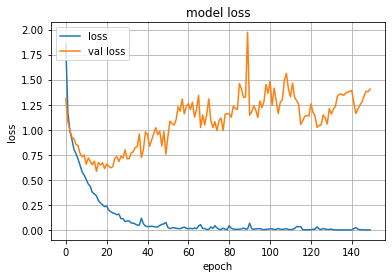

In [55]:
plt.figure()
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['loss', 'val loss'], loc='upper left')
plt.show()

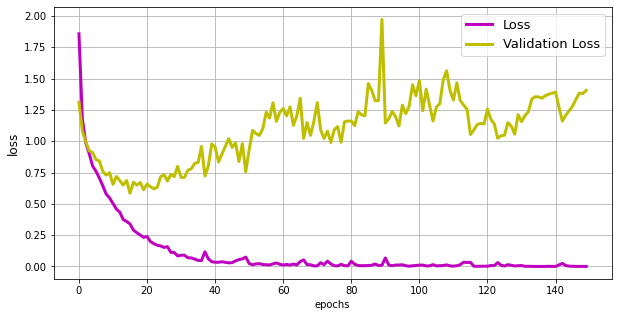

In [56]:
plt.figure(figsize=(10,5))

plt.plot(cnnhistory.history['loss'], 'm', linewidth=3)
plt.plot(cnnhistory.history['val_loss'], 'y', linewidth=3)
plt.legend(['Loss', 'Validation Loss'], fontsize=13)
plt.xlabel('epochs')
plt.ylabel('loss', fontsize=12)
plt.grid(True)
plt.show()

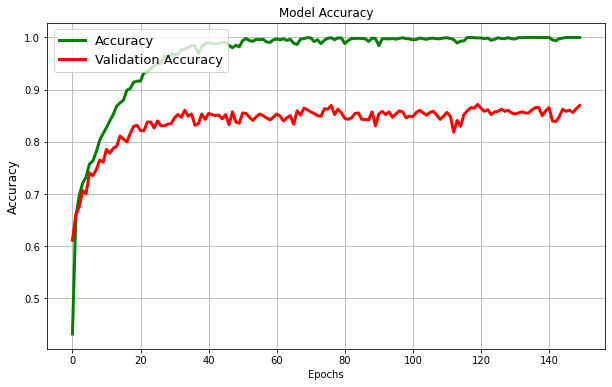

In [57]:
plt.figure(figsize=(10,6), frameon=True)

plt.plot(cnnhistory.history['accuracy'], 'g', linewidth=3)
plt.plot(cnnhistory.history['val_accuracy'], 'r', linewidth=3)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy', fontsize=12)

plt.legend(['Accuracy', 'Validation Accuracy'], loc = 'upper left', fontsize=13)
plt.grid(True)
plt.show()

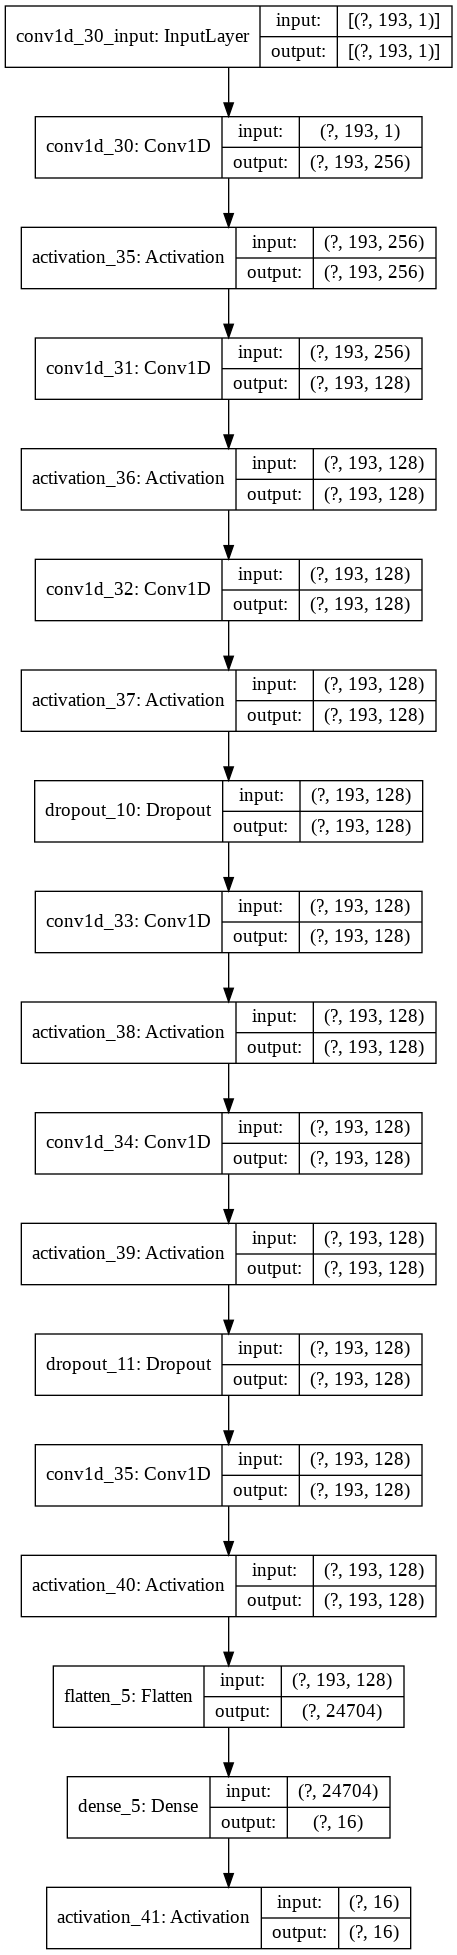

In [58]:
tf.keras.utils.plot_model(
    model,
    to_file="img_model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

dot_img_file = '/content/drive/My Drive/My_AI/img_model_07_RAVDESS-TESS-SAVEE.png'
tf.keras.utils.plot_model(model, to_file = dot_img_file, show_shapes=True)


SAVING THE MODEL

In [59]:
model_name = 'Emotion_Voice_Detection_CNN_model_07_RAVDESS-TESS-SAVEE.h5'
path = '/content/drive/My Drive/My_AI/MY MODELS/'
model_path = os.path.join(path, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/My_AI/MY MODELS/Emotion_Voice_Detection_CNN_model_07_RAVDESS-TESS-SAVEE.h5 


In [60]:
import json
model_json = model.to_json()
with open("/content/drive/My Drive/My_AI/MY MODELS/model_07_RAVDESS-TESS-SAVEE.json", "w") as json_file:
    json_file.write(model_json)

LOADING THE MODEL

In [13]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('/content/drive/My Drive/My_AI/MY MODELS/model_07_RAVDESS-TESS-SAVEE.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/My_AI/MY MODELS/Emotion_Voice_Detection_CNN_model_07_RAVDESS-TESS-SAVEE.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
opt = tf.keras.optimizers.Adam(learning_rate=0.0001) ###
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 97.62%


Predicting emotions on the test data

In [28]:
import pandas as pd

preds = loaded_model.predict(x_testcnn, batch_size=32, verbose=1)
preds1=preds.argmax(axis=1)

abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))
preddf = pd.DataFrame({'predictedvalues': predictions})

actual=y_test.argmax(axis=1)

abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

actualdf = pd.DataFrame({'actualvalues': actualvalues})
finaldf = actualdf.join(preddf)

finaldf[10:70]


28/28 [==============================] - 3s 105ms/step


,actualvalues,predictedvalues
10,female_sad,female_sad
11,male_disgust,male_disgust
12,female_angry,female_angry
13,female_angry,female_angry
14,female_sad,female_sad
15,male_angry,male_angry
16,female_neutral,female_neutral
17,male_calm,male_calm
18,female_fearful,female_fearful
19,female_disgust,female_disgust


In [15]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,89
female_calm,19
female_disgust,106
female_fearful,85
female_happy,103
female_neutral,87
female_sad,101
female_surprised,82
male_angry,28


In [16]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,87
female_calm,19
female_disgust,107
female_fearful,87
female_happy,102
female_neutral,87
female_sad,102
female_surprised,81
male_angry,25


In [17]:
finaldf.to_csv('Predictions_RAV-TESS-SAVEE.csv', index=False)

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))


                  precision    recall  f1-score   support

    female_angry       1.00      0.98      0.99        89
     female_calm       1.00      1.00      1.00        19
  female_disgust       0.99      1.00      1.00       106
  female_fearful       0.95      0.98      0.97        85
    female_happy       0.98      0.97      0.98       103
  female_neutral       0.99      0.99      0.99        87
      female_sad       0.99      1.00      1.00       101
female_surprised       1.00      0.99      0.99        82
      male_angry       0.96      0.86      0.91        28
       male_calm       0.94      1.00      0.97        15
    male_disgust       0.92      1.00      0.96        22
    male_fearful       0.91      1.00      0.96        32
      male_happy       0.94      0.91      0.93        35
    male_neutral       0.96      0.93      0.95        29
        male_sad       0.92      0.88      0.90        25
  male_surprised       1.00      1.00      1.00        26

        accu

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


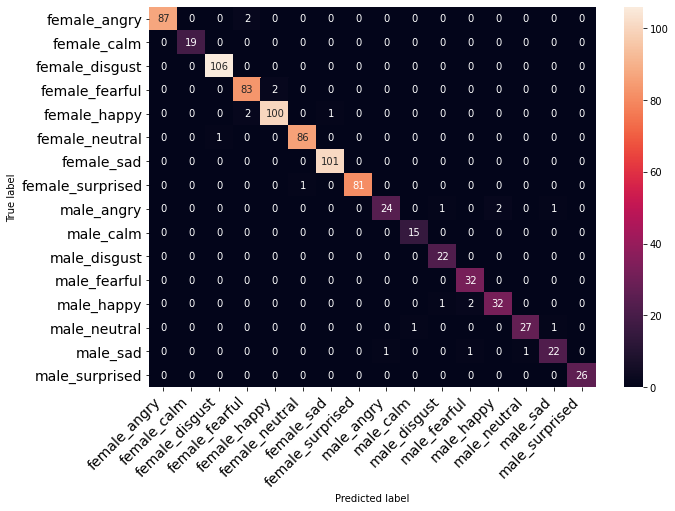

In [19]:
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fearful' or 'female_happy' or 'female_sad' or 'female_surprised' or 'female_neutral' or 'female_angry' or 'female_calm':
        return 'female'
    elif row ==  'male_disgust' or 'male_fearful' or 'male_happy' or 'male_sad' or 'male_surprised' or 'male_neutral' or 'male_angry' or 'male_calm':
        return 'male'

finaldf = pd.read_csv("Predictions_RAV-TESS-SAVEE.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
#print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

Populating the interactive namespace from numpy and matplotlib


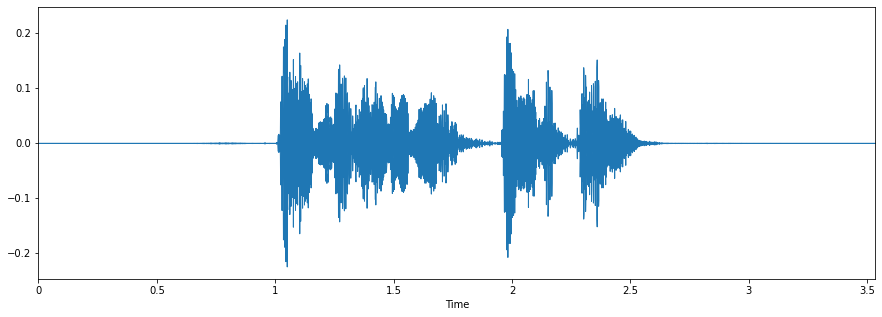

In [3]:
data, sampling_rate = librosa.load('/content/drive/My Drive/My_AI/RawData/03-01-08-02-02-02-21.wav')

% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [20]:
X, sample_rate = librosa.load('/content/drive/My Drive/My_AI/RawData/03-01-08-02-02-02-21.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)

demo_file = os.fspath('/content/drive/My Drive/My_AI/RawData/03-01-08-02-02-02-21.wav')
features_live  = extract_feature(demo_file, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True)

In [21]:
features_live = pd.DataFrame(data = features_live)
features_live = features_live.stack().to_frame().T

In [22]:
features_live_2d = np.expand_dims(features_live, axis=2)
live_preds = loaded_model.predict(features_live_2d, batch_size=32, verbose=1)
live_preds = live_preds.argmax(axis=1)
live_preds = live_preds.astype(int).flatten()

live_preds = (lb.inverse_transform((live_preds)))
live_preds

1/1 [==============================] - 0s 1ms/step


array(['male_surprised'], dtype=object)